In [214]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [215]:
# Parameters
model_to_use = 'pymer' # "pymer" or "rf"
pct_overlap_cutoff = 0.8

save_plots = True

In [216]:
# Read in effective AOH results
if model_to_use == 'pymer':
    aoh_info_fp = '/Users/emiliolr/Desktop/effective_aoh_info_pymer.csv'
elif model_to_use == 'rf':
    aoh_info_fp = '/Users/emiliolr/Desktop/effective_aoh_info_rf.csv'
    
aoh_info = pd.read_csv(aoh_info_fp)

In [217]:
# Read in taxonomic + body mass info for tropical mammal species
tropical_mammals_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/tropical_species/tropical_mammals_taxonomic_info_w_body_mass.csv'
tropical_mammals = pd.read_csv(tropical_mammals_fp)

#  join on tropical mammal info w/effective AOH results
aoh_info = pd.merge(aoh_info, tropical_mammals, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id', 'synonyms', 'is_species', 'combine_match_species', 
                                    'combine_bm_match_level'])

In [218]:
# Read in percent overlap w/tropical forest zone info (just current AOH overlap)
aoh_pct_overlap_fp = '/Users/emiliolr/Desktop/tropical_mammals_aoh_overlap.csv'
aoh_pct_overlap = pd.read_csv(aoh_pct_overlap_fp)
aoh_pct_overlap = aoh_pct_overlap.rename(columns = {'aoh_pct_overlap' : 'aoh_pct_overlap_current'})

#  join on percent overlap info w/effective AOH results
aoh_info = pd.merge(aoh_info, aoh_pct_overlap, how = 'left', left_on = 'species', right_on = 'iucn_id')
aoh_info = aoh_info.drop(columns = ['iucn_id'])

#  filter species by percent overlap cutoff
aoh_info = aoh_info[aoh_info['aoh_pct_overlap_current'] >= pct_overlap_cutoff]

In [219]:
# Adding columns to represent AOH percent changes: negative if AOH loss, positive if gain
aoh_info['Land-Cover'] = (aoh_info['current_aoh_total'] / aoh_info['human_absent_aoh_total']) - 1
aoh_info['Hunting'] = (aoh_info['human_absent_aoh_w_hunting_total'] / aoh_info['human_absent_aoh_total']) - 1
aoh_info['Combined'] = (aoh_info['current_aoh_w_hunting_total'] / aoh_info['human_absent_aoh_total']) - 1

In [221]:
# Adding a column for body mass category (matching Gallego-Zamorano)
def bm_cats(bm):
    if bm < 0.1:
        return 'very small'
    elif (bm >= 0.1) and (bm < 1):
        return 'small'
    elif (bm >= 1) and (bm < 10):
        return 'medium'
    else:
        return 'large'

aoh_info['body_mass_cat'] = (aoh_info['combine_body_mass'] / 1000).apply(bm_cats)
cat_counts = aoh_info['body_mass_cat'].value_counts()

In [222]:
# Removing a few CRAZY outliers w/huge gains due to contemporary habitat change
aoh_info = aoh_info[aoh_info['Land-Cover'] < 10]

In [223]:
# Pivoting into a wide format to make plotting easier
value_vars = ['Land-Cover', 'Hunting', 'Combined']
id_vars = [c for c in aoh_info.columns if c not in value_vars]
aoh_info = aoh_info.melt(id_vars = id_vars, value_vars = value_vars, var_name = 'aoh_loss_type', 
                         value_name = 'aoh_loss_amt')

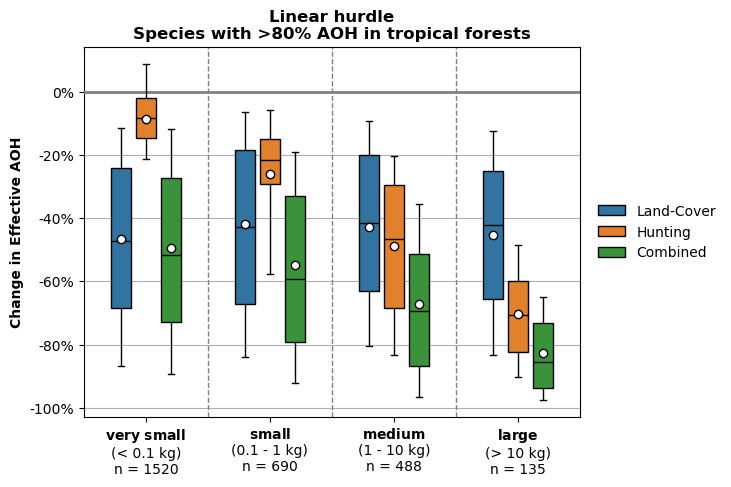

In [224]:
# Plotting effective AOHs by body mass category
bm_cat_order = ['very small', 'small', 'medium', 'large']
legend_labels = ['habitat loss', 'hunting', 'both']

sns.boxplot(data = aoh_info, x = 'body_mass_cat', y = 'aoh_loss_amt', hue = 'aoh_loss_type', order = bm_cat_order,
            showfliers = False, whis = (10, 90), width = 0.6, gap = 0.2, capwidths = 0.05, notch = False, linecolor = 'black',
            showmeans = True, meanprops = {'markeredgecolor' : 'black', 'marker' : 'o', 'markerfacecolor' : 'white'},
            zorder = 100)

#  adding line for no AOH change
plt.axhline(0, color = 'grey', linewidth = 2, zorder = 10)

for i in [0.5, 1.5, 2.5]:
    plt.axvline(i, color = 'grey', linewidth = 1, linestyle = '--')

#  labeling axes + title
plt.xlabel(None)
plt.ylabel('Change in Effective AOH', weight = 'bold')

if model_to_use == 'pymer':
    title = f'Linear hurdle\nSpecies with >{int(pct_overlap_cutoff * 100)}% AOH in tropical forests'
else:
    title = f'Random forest hurdle\nSpecies with >{int(pct_overlap_cutoff * 100)}% AOH in tropical forests'
plt.title(title, weight = 'bold')

#  fiddling w/tick formatting
if model_to_use == 'pymer':
    yticks = np.arange(-1, 0.2, 0.2)
else:
    yticks = np.arange(-1, 0.2, 0.2)
ytick_labels = [f'{round(float(i))}%' for i in yticks * 100]
plt.yticks(ticks = yticks, labels = ytick_labels)

xtick_labels = [r'$\bf{very\ small}$' + f'\n(< 0.1 kg)\nn = {cat_counts.loc["very small"]}', 
                r'$\bf{small}$' + f'\n(0.1 - 1 kg)\nn = {cat_counts.loc["small"]}', 
                r'$\bf{medium}$' + f'\n(1 - 10 kg)\nn = {cat_counts.loc["medium"]}',
                r'$\bf{large}$' + f'\n(> 10 kg)\nn = {cat_counts.loc["large"]}']
plt.xticks(ticks = [0, 1, 2, 3], labels = xtick_labels)

#  fixing the legend
plt.legend(loc = 'center right', bbox_to_anchor = (1.3, 0.5), frameon = False)

#  adding major gridlines
plt.grid(visible = True, which = 'major', axis = 'y')

#  optionally saving plot
if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_aoh_diff_cutoff={pct_overlap_cutoff}.png', 
                bbox_inches = 'tight', dpi = 400)

plt.show()

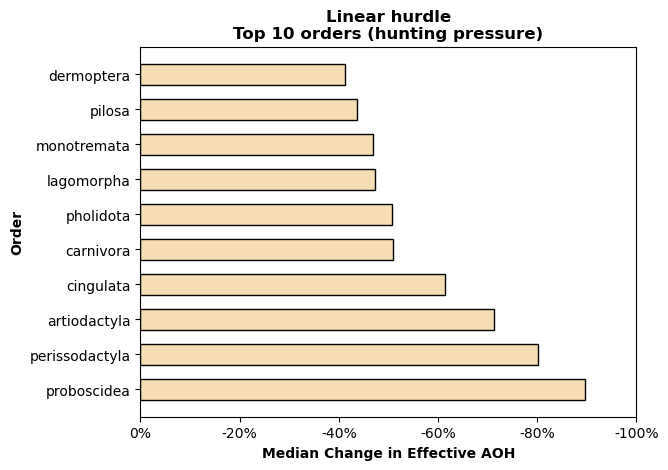

In [226]:
# Taxonomic summaries of change in effective AOH
tax_level = 'order'
loss_type = 'Hunting'
num_to_plot = 10
most_affected = True

# Grouping by family + extracting median effect
aoh_info_grouped = aoh_info[aoh_info['aoh_loss_type'] == loss_type].groupby([tax_level])

median_aoh_effect = aoh_info_grouped['aoh_loss_amt'].median().sort_values()
if most_affected:
    median_aoh_effect = median_aoh_effect.iloc[ : num_to_plot]
else:
    median_aoh_effect = median_aoh_effect.iloc[len(median_aoh_effect) - 1 - num_to_plot : ]
median_aoh_effect = median_aoh_effect.to_frame().reset_index()

# Plotting in barplot format
plt.barh(median_aoh_effect[tax_level], median_aoh_effect['aoh_loss_amt'] * -1, color = 'wheat', 
         edgecolor = 'black', height = 0.6)

plt.xlabel('Median Change in Effective AOH', weight = 'bold')
plt.ylabel(str(tax_level).title(), weight = 'bold')

xticks = plt.xticks()[0]
plt.xticks(xticks, [f'{"-" if x > 0 else ("+" if x < 0 else "")}{abs(int(x * 100))}%' for x in xticks])

if model_to_use == 'pymer':
    title = f'Linear hurdle\n{"Top" if most_affected else "Bottom"} {num_to_plot} {"orders" if tax_level == "order" else "families"} (hunting pressure)'
else:
    title = f'Random forest hurdle\n{"Top" if most_affected else "Bottom"} {num_to_plot} {"orders" if tax_level == "order" else "families"} (hunting pressure)'
plt.title(title, weight = 'bold')

if save_plots:
    plt.savefig(f'/Users/emiliolr/Desktop/{model_to_use}_tax_breakdown_{"top" if most_affected else "bottom"}{num_to_plot}.png', 
                bbox_inches = 'tight', dpi = 400)

In [271]:
import rioxarray as rxr

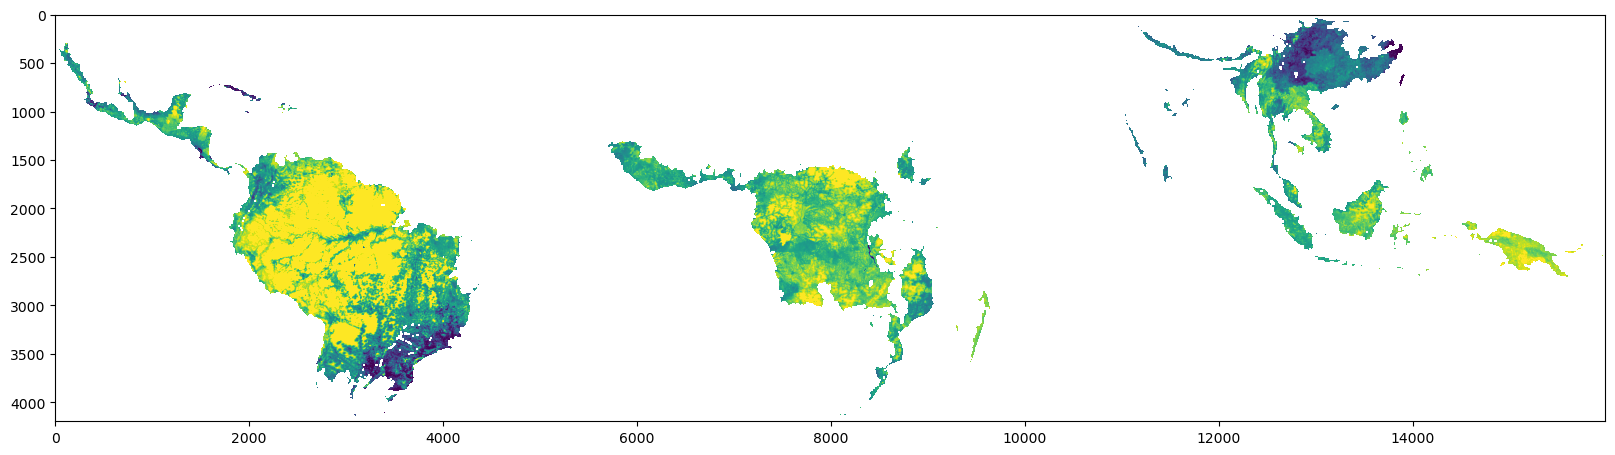

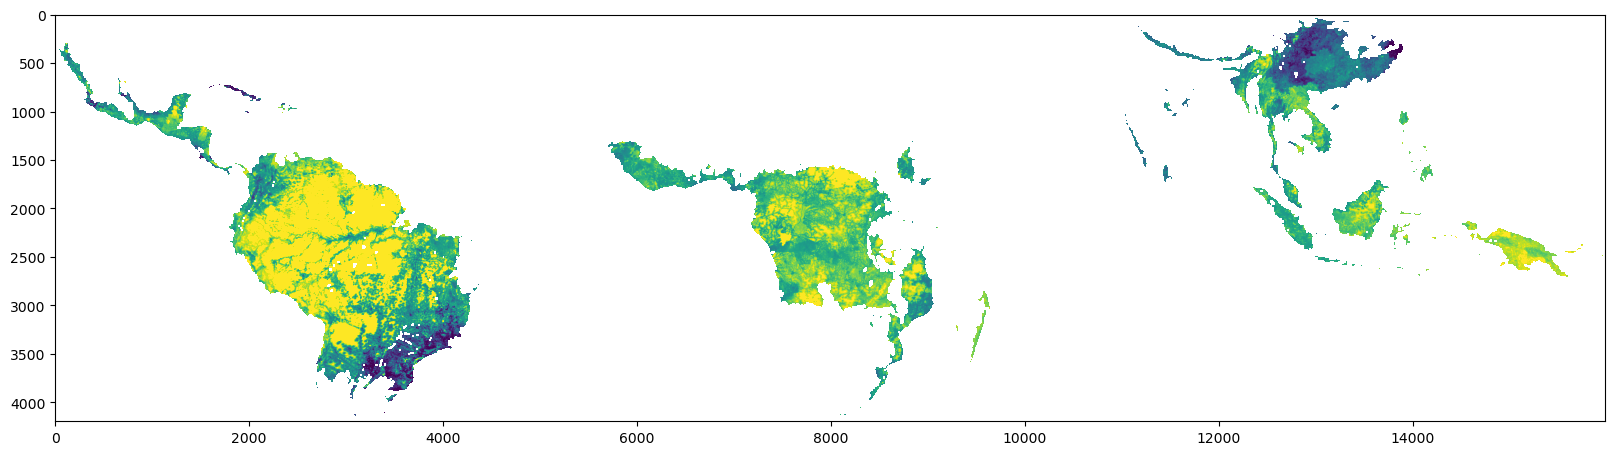

In [320]:
ex = rxr.open_rasterio('/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/hunting_predictor_stack/hunting_predictor_stack_buffered.tif')
ex_nan = xr.ufuncs.isnan(ex).astype(int).sum(dim = 'band')
# ex_mask = ex_nan.where(ex_nan == 0)

ex_hunting = rxr.open_rasterio('/Users/emiliolr/Desktop/hunting_results/tropical_species_aggregate_hunting_pressure_pymer.tif')
plt.figure(figsize = (20, 20))
plt.imshow(ex_hunting.squeeze(), vmin = 0, vmax = 1)
plt.show()

ex_nan = ex_nan.rio.reproject_match(ex_hunting)
ex_hunting = ex_hunting.where(ex_nan == 0)
plt.figure(figsize = (20, 20))
plt.imshow(ex_hunting.squeeze(), vmin = 0, vmax = 1)
plt.show()

In [321]:
ex_hunting.rio.to_raster('/Users/emiliolr/Desktop/TEST.tif')